In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
# Om			\Omega_m
# Obh2			\Omega_{b}h^2
# h	
datafile = 'chains/LCDM_phy_HD_nested_dynesty_multi_1.txt'

In [4]:
class LoadDataSet(torch.utils.data.Dataset):
    '''
    Prepare the dataset for regression
    '''
    def __init__(self, X, y, scale_data=False):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        ncols = 3
        self.layers = nn.Sequential(
          nn.Linear(ncols, 200),
          nn.ReLU(),
          nn.Linear(200, 200),
          nn.ReLU(),
          nn.Linear(200, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [6]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(42)
  
    # Load Boston dataset
    X = np.loadtxt(datafile, usecols=(2,3,4))
    y = np.loadtxt(datafile, usecols=1).reshape(-1, 1)
    randomize = np.random.permutation(len(X))
    X = X[randomize]
    y = y[randomize]
    print(np.shape(X), np.shape(y))
    X_test, y_test = X[:100, :], y[:100, :]
    X, y = X[100:, :], y[100:, :]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

(1036, 3) (1036, 1)


In [7]:
dataset_train = LoadDataSet(X_train, y_train)
dataset_val = LoadDataSet(X_val, y_val)
# dataset_test = LoadDataSet(X_test, y_test)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [8]:
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(dataset_val, batch_size=2, shuffle=True, num_workers=1)

In [9]:
# Initialize the MLP
mlp = MLP()
mlp.float()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [10]:
summary(mlp, batch_size=-1)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0

In [11]:
# Run the training loop
history_train = np.empty((1,))
history_val = np.empty((1,))
for epoch in range(0, 300): # 5 epochs at maximum  
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
                  (i + 1, loss.item()))
            current_loss = 0.0
    history_train = np.append(history_train, current_loss)

    
    valid_loss = 0.0
    mlp.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(validloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        output_val = mlp(inputs)
        valid_loss = loss_function(output_val, targets)
    
        valid_loss += loss.item()
    history_val = np.append(history_val, valid_loss.item())
    print('Training Loss: {:.3f} \t\t Validation Loss:'\
         '{:.3f}'.format(loss.item(), valid_loss.item()))
#     print('Training Loss: {:.3f} \t\t Validation Loss:'\
#           '{:.3f}'.format(current_loss / len(trainloader), valid_loss / len(validloader)))
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 7.287
Loss after mini-batch    11: 25.879
Loss after mini-batch    21: 38.638
Loss after mini-batch    31: 59.193
Loss after mini-batch    41: 10.342
Loss after mini-batch    51: 17.420
Loss after mini-batch    61: 6.859
Loss after mini-batch    71: 7.086
Loss after mini-batch    81: 31.922
Loss after mini-batch    91: 6.557
Loss after mini-batch   101: 20.511
Loss after mini-batch   111: 5.822
Loss after mini-batch   121: 5.637
Loss after mini-batch   131: 5.506
Loss after mini-batch   141: 7.195
Loss after mini-batch   151: 5.422
Loss after mini-batch   161: 4.679
Loss after mini-batch   171: 8.138
Loss after mini-batch   181: 4.323
Loss after mini-batch   191: 3.785
Loss after mini-batch   201: 5.513
Loss after mini-batch   211: 6.177
Loss after mini-batch   221: 4.968
Loss after mini-batch   231: 8.735
Loss after mini-batch   241: 8.255
Loss after mini-batch   251: 19.817
Loss after mini-batch   261: 1.419
Loss after mini-batch   271: 1

Loss after mini-batch   361: 0.402
Loss after mini-batch   371: 8.020
Training Loss: 6.675 		 Validation Loss:10.744
Starting epoch 7
Loss after mini-batch     1: 0.312
Loss after mini-batch    11: 0.616
Loss after mini-batch    21: 0.540
Loss after mini-batch    31: 0.554
Loss after mini-batch    41: 25.472
Loss after mini-batch    51: 18.799
Loss after mini-batch    61: 3.261
Loss after mini-batch    71: 1.000
Loss after mini-batch    81: 0.603
Loss after mini-batch    91: 1.872
Loss after mini-batch   101: 15.573
Loss after mini-batch   111: 0.705
Loss after mini-batch   121: 5.949
Loss after mini-batch   131: 0.393
Loss after mini-batch   141: 14.682
Loss after mini-batch   151: 0.736
Loss after mini-batch   161: 0.682
Loss after mini-batch   171: 10.006
Loss after mini-batch   181: 0.992
Loss after mini-batch   191: 0.489
Loss after mini-batch   201: 0.493
Loss after mini-batch   211: 10.507
Loss after mini-batch   221: 13.735
Loss after mini-batch   231: 0.637
Loss after mini-bat

Training Loss: 0.858 		 Validation Loss:1.423
Starting epoch 13
Loss after mini-batch     1: 0.835
Loss after mini-batch    11: 1.659
Loss after mini-batch    21: 1.230
Loss after mini-batch    31: 1.166
Loss after mini-batch    41: 0.508
Loss after mini-batch    51: 0.674
Loss after mini-batch    61: 1.273
Loss after mini-batch    71: 0.579
Loss after mini-batch    81: 0.511
Loss after mini-batch    91: 9.017
Loss after mini-batch   101: 0.651
Loss after mini-batch   111: 25.325
Loss after mini-batch   121: 1.933
Loss after mini-batch   131: 3.112
Loss after mini-batch   141: 7.063
Loss after mini-batch   151: 8.162
Loss after mini-batch   161: 5.256
Loss after mini-batch   171: 0.536
Loss after mini-batch   181: 0.593
Loss after mini-batch   191: 0.698
Loss after mini-batch   201: 0.483
Loss after mini-batch   211: 0.215
Loss after mini-batch   221: 17.962
Loss after mini-batch   231: 1.831
Loss after mini-batch   241: 0.552
Loss after mini-batch   251: 2.408
Loss after mini-batch   

Training Loss: 1.249 		 Validation Loss:2.175
Starting epoch 19
Loss after mini-batch     1: 2.976
Loss after mini-batch    11: 0.485
Loss after mini-batch    21: 31.497
Loss after mini-batch    31: 1.024
Loss after mini-batch    41: 13.391
Loss after mini-batch    51: 2.522
Loss after mini-batch    61: 2.870
Loss after mini-batch    71: 2.785
Loss after mini-batch    81: 0.262
Loss after mini-batch    91: 3.519
Loss after mini-batch   101: 0.291
Loss after mini-batch   111: 5.959
Loss after mini-batch   121: 0.303
Loss after mini-batch   131: 4.712
Loss after mini-batch   141: 8.319
Loss after mini-batch   151: 0.407
Loss after mini-batch   161: 2.607
Loss after mini-batch   171: 0.265
Loss after mini-batch   181: 3.058
Loss after mini-batch   191: 10.680
Loss after mini-batch   201: 14.379
Loss after mini-batch   211: 2.784
Loss after mini-batch   221: 10.557
Loss after mini-batch   231: 0.237
Loss after mini-batch   241: 0.755
Loss after mini-batch   251: 0.701
Loss after mini-batch

Training Loss: 6.526 		 Validation Loss:11.345
Starting epoch 25
Loss after mini-batch     1: 12.817
Loss after mini-batch    11: 3.027
Loss after mini-batch    21: 0.253
Loss after mini-batch    31: 1.845
Loss after mini-batch    41: 1.363
Loss after mini-batch    51: 2.060
Loss after mini-batch    61: 2.746
Loss after mini-batch    71: 1.038
Loss after mini-batch    81: 0.966
Loss after mini-batch    91: 1.024
Loss after mini-batch   101: 0.232
Loss after mini-batch   111: 0.293
Loss after mini-batch   121: 4.179
Loss after mini-batch   131: 1.381
Loss after mini-batch   141: 0.350
Loss after mini-batch   151: 0.656
Loss after mini-batch   161: 10.008
Loss after mini-batch   171: 13.674
Loss after mini-batch   181: 8.203
Loss after mini-batch   191: 2.537
Loss after mini-batch   201: 24.403
Loss after mini-batch   211: 8.378
Loss after mini-batch   221: 8.801
Loss after mini-batch   231: 3.484
Loss after mini-batch   241: 0.221
Loss after mini-batch   251: 2.494
Loss after mini-batch

Training Loss: 0.328 		 Validation Loss:1.423
Starting epoch 31
Loss after mini-batch     1: 5.797
Loss after mini-batch    11: 0.193
Loss after mini-batch    21: 0.255
Loss after mini-batch    31: 0.067
Loss after mini-batch    41: 6.807
Loss after mini-batch    51: 7.114
Loss after mini-batch    61: 21.453
Loss after mini-batch    71: 7.303
Loss after mini-batch    81: 0.237
Loss after mini-batch    91: 10.617
Loss after mini-batch   101: 0.351
Loss after mini-batch   111: 1.261
Loss after mini-batch   121: 2.783
Loss after mini-batch   131: 8.855
Loss after mini-batch   141: 0.429
Loss after mini-batch   151: 0.211
Loss after mini-batch   161: 0.859
Loss after mini-batch   171: 1.553
Loss after mini-batch   181: 3.346
Loss after mini-batch   191: 0.577
Loss after mini-batch   201: 0.489
Loss after mini-batch   211: 6.658
Loss after mini-batch   221: 0.762
Loss after mini-batch   231: 0.361
Loss after mini-batch   241: 27.737
Loss after mini-batch   251: 0.184
Loss after mini-batch  

Training Loss: 10.133 		 Validation Loss:33.365
Starting epoch 37
Loss after mini-batch     1: 0.532
Loss after mini-batch    11: 0.435
Loss after mini-batch    21: 0.332
Loss after mini-batch    31: 0.285
Loss after mini-batch    41: 5.088
Loss after mini-batch    51: 7.521
Loss after mini-batch    61: 0.375
Loss after mini-batch    71: 0.659
Loss after mini-batch    81: 0.218
Loss after mini-batch    91: 0.937
Loss after mini-batch   101: 0.010
Loss after mini-batch   111: 0.737
Loss after mini-batch   121: 3.715
Loss after mini-batch   131: 12.729
Loss after mini-batch   141: 16.297
Loss after mini-batch   151: 0.984
Loss after mini-batch   161: 27.312
Loss after mini-batch   171: 10.904
Loss after mini-batch   181: 0.320
Loss after mini-batch   191: 4.031
Loss after mini-batch   201: 0.629
Loss after mini-batch   211: 1.998
Loss after mini-batch   221: 2.872
Loss after mini-batch   231: 4.250
Loss after mini-batch   241: 0.276
Loss after mini-batch   251: 3.414
Loss after mini-batc

Training Loss: 1.510 		 Validation Loss:21.933
Starting epoch 43
Loss after mini-batch     1: 1.491
Loss after mini-batch    11: 5.344
Loss after mini-batch    21: 0.127
Loss after mini-batch    31: 7.323
Loss after mini-batch    41: 9.631
Loss after mini-batch    51: 0.456
Loss after mini-batch    61: 19.383
Loss after mini-batch    71: 11.973
Loss after mini-batch    81: 1.055
Loss after mini-batch    91: 2.360
Loss after mini-batch   101: 0.578
Loss after mini-batch   111: 0.913
Loss after mini-batch   121: 0.699
Loss after mini-batch   131: 0.603
Loss after mini-batch   141: 2.157
Loss after mini-batch   151: 0.318
Loss after mini-batch   161: 11.197
Loss after mini-batch   171: 7.771
Loss after mini-batch   181: 3.819
Loss after mini-batch   191: 1.448
Loss after mini-batch   201: 0.780
Loss after mini-batch   211: 0.876
Loss after mini-batch   221: 1.022
Loss after mini-batch   231: 0.482
Loss after mini-batch   241: 2.760
Loss after mini-batch   251: 13.977
Loss after mini-batch

Training Loss: 1.075 		 Validation Loss:3.323
Starting epoch 49
Loss after mini-batch     1: 1.788
Loss after mini-batch    11: 17.835
Loss after mini-batch    21: 1.669
Loss after mini-batch    31: 19.001
Loss after mini-batch    41: 1.934
Loss after mini-batch    51: 0.454
Loss after mini-batch    61: 3.196
Loss after mini-batch    71: 7.472
Loss after mini-batch    81: 0.338
Loss after mini-batch    91: 1.130
Loss after mini-batch   101: 1.154
Loss after mini-batch   111: 0.813
Loss after mini-batch   121: 20.553
Loss after mini-batch   131: 3.773
Loss after mini-batch   141: 0.065
Loss after mini-batch   151: 1.644
Loss after mini-batch   161: 2.894
Loss after mini-batch   171: 0.129
Loss after mini-batch   181: 6.603
Loss after mini-batch   191: 14.167
Loss after mini-batch   201: 7.296
Loss after mini-batch   211: 0.920
Loss after mini-batch   221: 3.482
Loss after mini-batch   231: 0.683
Loss after mini-batch   241: 2.309
Loss after mini-batch   251: 8.427
Loss after mini-batch 

Training Loss: 11.977 		 Validation Loss:12.199
Starting epoch 55
Loss after mini-batch     1: 10.602
Loss after mini-batch    11: 2.259
Loss after mini-batch    21: 0.228
Loss after mini-batch    31: 0.037
Loss after mini-batch    41: 5.920
Loss after mini-batch    51: 2.031
Loss after mini-batch    61: 0.226
Loss after mini-batch    71: 1.189
Loss after mini-batch    81: 1.770
Loss after mini-batch    91: 13.459
Loss after mini-batch   101: 2.026
Loss after mini-batch   111: 0.122
Loss after mini-batch   121: 0.689
Loss after mini-batch   131: 6.100
Loss after mini-batch   141: 5.712
Loss after mini-batch   151: 3.977
Loss after mini-batch   161: 0.032
Loss after mini-batch   171: 0.204
Loss after mini-batch   181: 7.656
Loss after mini-batch   191: 0.633
Loss after mini-batch   201: 0.617
Loss after mini-batch   211: 1.973
Loss after mini-batch   221: 6.369
Loss after mini-batch   231: 2.310
Loss after mini-batch   241: 0.799
Loss after mini-batch   251: 0.433
Loss after mini-batch 

Training Loss: 1.324 		 Validation Loss:34.815
Starting epoch 61
Loss after mini-batch     1: 26.219
Loss after mini-batch    11: 1.041
Loss after mini-batch    21: 0.621
Loss after mini-batch    31: 0.199
Loss after mini-batch    41: 1.489
Loss after mini-batch    51: 1.840
Loss after mini-batch    61: 0.162
Loss after mini-batch    71: 5.880
Loss after mini-batch    81: 0.108
Loss after mini-batch    91: 1.593
Loss after mini-batch   101: 0.028
Loss after mini-batch   111: 0.023
Loss after mini-batch   121: 0.471
Loss after mini-batch   131: 5.664
Loss after mini-batch   141: 1.306
Loss after mini-batch   151: 0.270
Loss after mini-batch   161: 9.272
Loss after mini-batch   171: 0.107
Loss after mini-batch   181: 0.920
Loss after mini-batch   191: 0.195
Loss after mini-batch   201: 0.940
Loss after mini-batch   211: 2.205
Loss after mini-batch   221: 3.318
Loss after mini-batch   231: 0.104
Loss after mini-batch   241: 17.908
Loss after mini-batch   251: 1.176
Loss after mini-batch  

Training Loss: 0.103 		 Validation Loss:0.357
Starting epoch 67
Loss after mini-batch     1: 0.372
Loss after mini-batch    11: 1.386
Loss after mini-batch    21: 1.463
Loss after mini-batch    31: 3.059
Loss after mini-batch    41: 1.079
Loss after mini-batch    51: 0.013
Loss after mini-batch    61: 5.314
Loss after mini-batch    71: 0.614
Loss after mini-batch    81: 5.193
Loss after mini-batch    91: 6.718
Loss after mini-batch   101: 0.218
Loss after mini-batch   111: 0.839
Loss after mini-batch   121: 1.714
Loss after mini-batch   131: 4.407
Loss after mini-batch   141: 0.449
Loss after mini-batch   151: 0.096
Loss after mini-batch   161: 9.628
Loss after mini-batch   171: 0.403
Loss after mini-batch   181: 4.083
Loss after mini-batch   191: 0.047
Loss after mini-batch   201: 2.483
Loss after mini-batch   211: 6.430
Loss after mini-batch   221: 1.036
Loss after mini-batch   231: 3.754
Loss after mini-batch   241: 8.161
Loss after mini-batch   251: 3.762
Loss after mini-batch   26

Training Loss: 1.733 		 Validation Loss:9.333
Starting epoch 73
Loss after mini-batch     1: 3.955
Loss after mini-batch    11: 15.072
Loss after mini-batch    21: 1.375
Loss after mini-batch    31: 5.590
Loss after mini-batch    41: 14.057
Loss after mini-batch    51: 3.159
Loss after mini-batch    61: 0.286
Loss after mini-batch    71: 0.805
Loss after mini-batch    81: 1.655
Loss after mini-batch    91: 0.151
Loss after mini-batch   101: 0.151
Loss after mini-batch   111: 6.939
Loss after mini-batch   121: 18.936
Loss after mini-batch   131: 1.734
Loss after mini-batch   141: 1.857
Loss after mini-batch   151: 2.146
Loss after mini-batch   161: 1.595
Loss after mini-batch   171: 1.941
Loss after mini-batch   181: 0.915
Loss after mini-batch   191: 7.629
Loss after mini-batch   201: 0.542
Loss after mini-batch   211: 2.640
Loss after mini-batch   221: 0.646
Loss after mini-batch   231: 0.066
Loss after mini-batch   241: 1.549
Loss after mini-batch   251: 1.141
Loss after mini-batch  

Training Loss: 0.418 		 Validation Loss:7.893
Starting epoch 79
Loss after mini-batch     1: 3.430
Loss after mini-batch    11: 4.230
Loss after mini-batch    21: 0.273
Loss after mini-batch    31: 0.045
Loss after mini-batch    41: 4.005
Loss after mini-batch    51: 0.056
Loss after mini-batch    61: 0.427
Loss after mini-batch    71: 3.087
Loss after mini-batch    81: 32.291
Loss after mini-batch    91: 0.129
Loss after mini-batch   101: 0.056
Loss after mini-batch   111: 2.698
Loss after mini-batch   121: 0.079
Loss after mini-batch   131: 6.231
Loss after mini-batch   141: 9.935
Loss after mini-batch   151: 0.151
Loss after mini-batch   161: 6.139
Loss after mini-batch   171: 13.921
Loss after mini-batch   181: 0.136
Loss after mini-batch   191: 8.057
Loss after mini-batch   201: 16.061
Loss after mini-batch   211: 1.363
Loss after mini-batch   221: 1.841
Loss after mini-batch   231: 0.650
Loss after mini-batch   241: 4.555
Loss after mini-batch   251: 0.024
Loss after mini-batch  

Loss after mini-batch   371: 9.852
Training Loss: 24.856 		 Validation Loss:24.909
Starting epoch 85
Loss after mini-batch     1: 25.244
Loss after mini-batch    11: 0.461
Loss after mini-batch    21: 0.044
Loss after mini-batch    31: 13.940
Loss after mini-batch    41: 3.736
Loss after mini-batch    51: 0.840
Loss after mini-batch    61: 1.763
Loss after mini-batch    71: 2.592
Loss after mini-batch    81: 7.871
Loss after mini-batch    91: 0.189
Loss after mini-batch   101: 0.146
Loss after mini-batch   111: 5.551
Loss after mini-batch   121: 2.052
Loss after mini-batch   131: 11.228
Loss after mini-batch   141: 4.084
Loss after mini-batch   151: 0.203
Loss after mini-batch   161: 1.266
Loss after mini-batch   171: 0.169
Loss after mini-batch   181: 1.224
Loss after mini-batch   191: 12.673
Loss after mini-batch   201: 0.114
Loss after mini-batch   211: 0.163
Loss after mini-batch   221: 0.322
Loss after mini-batch   231: 19.193
Loss after mini-batch   241: 10.353
Loss after mini-ba

Training Loss: 0.525 		 Validation Loss:0.792
Starting epoch 91
Loss after mini-batch     1: 6.033
Loss after mini-batch    11: 0.043
Loss after mini-batch    21: 1.908
Loss after mini-batch    31: 0.117
Loss after mini-batch    41: 0.449
Loss after mini-batch    51: 0.084
Loss after mini-batch    61: 0.034
Loss after mini-batch    71: 2.725
Loss after mini-batch    81: 0.725
Loss after mini-batch    91: 0.124
Loss after mini-batch   101: 2.813
Loss after mini-batch   111: 3.502
Loss after mini-batch   121: 0.193
Loss after mini-batch   131: 0.139
Loss after mini-batch   141: 23.209
Loss after mini-batch   151: 3.945
Loss after mini-batch   161: 0.281
Loss after mini-batch   171: 1.524
Loss after mini-batch   181: 6.195
Loss after mini-batch   191: 0.084
Loss after mini-batch   201: 0.192
Loss after mini-batch   211: 7.298
Loss after mini-batch   221: 0.461
Loss after mini-batch   231: 0.318
Loss after mini-batch   241: 0.298
Loss after mini-batch   251: 15.275
Loss after mini-batch   

Training Loss: 3.778 		 Validation Loss:4.210
Starting epoch 97
Loss after mini-batch     1: 0.408
Loss after mini-batch    11: 6.915
Loss after mini-batch    21: 1.191
Loss after mini-batch    31: 0.668
Loss after mini-batch    41: 0.468
Loss after mini-batch    51: 0.383
Loss after mini-batch    61: 1.704
Loss after mini-batch    71: 0.252
Loss after mini-batch    81: 0.473
Loss after mini-batch    91: 8.417
Loss after mini-batch   101: 5.020
Loss after mini-batch   111: 0.057
Loss after mini-batch   121: 6.679
Loss after mini-batch   131: 1.110
Loss after mini-batch   141: 1.236
Loss after mini-batch   151: 0.158
Loss after mini-batch   161: 0.635
Loss after mini-batch   171: 0.053
Loss after mini-batch   181: 2.197
Loss after mini-batch   191: 0.046
Loss after mini-batch   201: 1.967
Loss after mini-batch   211: 0.064
Loss after mini-batch   221: 3.465
Loss after mini-batch   231: 1.395
Loss after mini-batch   241: 2.092
Loss after mini-batch   251: 0.147
Loss after mini-batch   26

Training Loss: 11.127 		 Validation Loss:12.743
Starting epoch 103
Loss after mini-batch     1: 0.085
Loss after mini-batch    11: 0.686
Loss after mini-batch    21: 6.594
Loss after mini-batch    31: 0.703
Loss after mini-batch    41: 0.310
Loss after mini-batch    51: 0.220
Loss after mini-batch    61: 3.120
Loss after mini-batch    71: 2.469
Loss after mini-batch    81: 5.333
Loss after mini-batch    91: 0.087
Loss after mini-batch   101: 13.412
Loss after mini-batch   111: 4.109
Loss after mini-batch   121: 7.395
Loss after mini-batch   131: 0.255
Loss after mini-batch   141: 0.281
Loss after mini-batch   151: 2.341
Loss after mini-batch   161: 0.414
Loss after mini-batch   171: 0.167
Loss after mini-batch   181: 3.108
Loss after mini-batch   191: 2.133
Loss after mini-batch   201: 1.460
Loss after mini-batch   211: 0.487
Loss after mini-batch   221: 3.464
Loss after mini-batch   231: 0.485
Loss after mini-batch   241: 1.835
Loss after mini-batch   251: 0.679
Loss after mini-batch 

Training Loss: 11.191 		 Validation Loss:12.974
Starting epoch 109
Loss after mini-batch     1: 0.222
Loss after mini-batch    11: 10.264
Loss after mini-batch    21: 1.752
Loss after mini-batch    31: 2.375
Loss after mini-batch    41: 7.414
Loss after mini-batch    51: 0.578
Loss after mini-batch    61: 0.318
Loss after mini-batch    71: 1.181
Loss after mini-batch    81: 1.039
Loss after mini-batch    91: 0.454
Loss after mini-batch   101: 0.144
Loss after mini-batch   111: 0.222
Loss after mini-batch   121: 0.314
Loss after mini-batch   131: 0.196
Loss after mini-batch   141: 0.200
Loss after mini-batch   151: 0.215
Loss after mini-batch   161: 0.029
Loss after mini-batch   171: 1.828
Loss after mini-batch   181: 0.176
Loss after mini-batch   191: 0.444
Loss after mini-batch   201: 0.514
Loss after mini-batch   211: 0.120
Loss after mini-batch   221: 0.387
Loss after mini-batch   231: 1.399
Loss after mini-batch   241: 0.274
Loss after mini-batch   251: 0.040
Loss after mini-batch 

Training Loss: 0.176 		 Validation Loss:1.324
Starting epoch 115
Loss after mini-batch     1: 0.250
Loss after mini-batch    11: 9.210
Loss after mini-batch    21: 6.437
Loss after mini-batch    31: 1.317
Loss after mini-batch    41: 0.372
Loss after mini-batch    51: 0.161
Loss after mini-batch    61: 2.686
Loss after mini-batch    71: 0.172
Loss after mini-batch    81: 0.403
Loss after mini-batch    91: 1.125
Loss after mini-batch   101: 4.424
Loss after mini-batch   111: 0.086
Loss after mini-batch   121: 1.072
Loss after mini-batch   131: 0.702
Loss after mini-batch   141: 0.228
Loss after mini-batch   151: 0.076
Loss after mini-batch   161: 0.486
Loss after mini-batch   171: 1.203
Loss after mini-batch   181: 0.161
Loss after mini-batch   191: 0.148
Loss after mini-batch   201: 3.412
Loss after mini-batch   211: 4.039
Loss after mini-batch   221: 1.132
Loss after mini-batch   231: 0.551
Loss after mini-batch   241: 0.718
Loss after mini-batch   251: 5.504
Loss after mini-batch   2

Training Loss: 1.669 		 Validation Loss:2.044
Starting epoch 121
Loss after mini-batch     1: 1.130
Loss after mini-batch    11: 0.079
Loss after mini-batch    21: 1.030
Loss after mini-batch    31: 0.666
Loss after mini-batch    41: 2.597
Loss after mini-batch    51: 3.747
Loss after mini-batch    61: 0.441
Loss after mini-batch    71: 0.526
Loss after mini-batch    81: 0.318
Loss after mini-batch    91: 1.117
Loss after mini-batch   101: 2.965
Loss after mini-batch   111: 2.148
Loss after mini-batch   121: 5.868
Loss after mini-batch   131: 0.133
Loss after mini-batch   141: 0.408
Loss after mini-batch   151: 0.234
Loss after mini-batch   161: 0.307
Loss after mini-batch   171: 0.290
Loss after mini-batch   181: 0.365
Loss after mini-batch   191: 1.005
Loss after mini-batch   201: 5.897
Loss after mini-batch   211: 0.279
Loss after mini-batch   221: 0.174
Loss after mini-batch   231: 2.782
Loss after mini-batch   241: 1.631
Loss after mini-batch   251: 0.462
Loss after mini-batch   2

Training Loss: 0.088 		 Validation Loss:0.799
Starting epoch 127
Loss after mini-batch     1: 0.615
Loss after mini-batch    11: 11.493
Loss after mini-batch    21: 0.902
Loss after mini-batch    31: 1.149
Loss after mini-batch    41: 0.084
Loss after mini-batch    51: 0.223
Loss after mini-batch    61: 1.028
Loss after mini-batch    71: 0.215
Loss after mini-batch    81: 4.554
Loss after mini-batch    91: 3.495
Loss after mini-batch   101: 1.701
Loss after mini-batch   111: 0.262
Loss after mini-batch   121: 2.876
Loss after mini-batch   131: 3.837
Loss after mini-batch   141: 0.411
Loss after mini-batch   151: 0.483
Loss after mini-batch   161: 0.253
Loss after mini-batch   171: 0.382
Loss after mini-batch   181: 2.205
Loss after mini-batch   191: 0.119
Loss after mini-batch   201: 0.065
Loss after mini-batch   211: 0.754
Loss after mini-batch   221: 0.405
Loss after mini-batch   231: 0.189
Loss after mini-batch   241: 0.629
Loss after mini-batch   251: 0.047
Loss after mini-batch   

Training Loss: 1.333 		 Validation Loss:7.090
Starting epoch 133
Loss after mini-batch     1: 0.046
Loss after mini-batch    11: 0.378
Loss after mini-batch    21: 0.487
Loss after mini-batch    31: 1.681
Loss after mini-batch    41: 2.522
Loss after mini-batch    51: 1.190
Loss after mini-batch    61: 0.491
Loss after mini-batch    71: 0.546
Loss after mini-batch    81: 2.250
Loss after mini-batch    91: 4.651
Loss after mini-batch   101: 0.766
Loss after mini-batch   111: 0.167
Loss after mini-batch   121: 2.174
Loss after mini-batch   131: 0.329
Loss after mini-batch   141: 0.038
Loss after mini-batch   151: 0.388
Loss after mini-batch   161: 0.613
Loss after mini-batch   171: 2.181
Loss after mini-batch   181: 0.271
Loss after mini-batch   191: 0.195
Loss after mini-batch   201: 1.690
Loss after mini-batch   211: 5.566
Loss after mini-batch   221: 0.434
Loss after mini-batch   231: 0.810
Loss after mini-batch   241: 10.749
Loss after mini-batch   251: 0.188
Loss after mini-batch   

Training Loss: 7.353 		 Validation Loss:7.890
Starting epoch 139
Loss after mini-batch     1: 0.162
Loss after mini-batch    11: 0.473
Loss after mini-batch    21: 2.310
Loss after mini-batch    31: 3.236
Loss after mini-batch    41: 0.117
Loss after mini-batch    51: 0.633
Loss after mini-batch    61: 0.116
Loss after mini-batch    71: 0.450
Loss after mini-batch    81: 0.214
Loss after mini-batch    91: 4.706
Loss after mini-batch   101: 2.165
Loss after mini-batch   111: 1.925
Loss after mini-batch   121: 2.794
Loss after mini-batch   131: 0.562
Loss after mini-batch   141: 1.450
Loss after mini-batch   151: 9.734
Loss after mini-batch   161: 1.685
Loss after mini-batch   171: 22.819
Loss after mini-batch   181: 0.740
Loss after mini-batch   191: 0.947
Loss after mini-batch   201: 1.353
Loss after mini-batch   211: 1.658
Loss after mini-batch   221: 0.034
Loss after mini-batch   231: 1.412
Loss after mini-batch   241: 0.257
Loss after mini-batch   251: 0.967
Loss after mini-batch   

Training Loss: 0.486 		 Validation Loss:0.617
Starting epoch 145
Loss after mini-batch     1: 4.639
Loss after mini-batch    11: 0.688
Loss after mini-batch    21: 0.381
Loss after mini-batch    31: 0.425
Loss after mini-batch    41: 10.028
Loss after mini-batch    51: 0.050
Loss after mini-batch    61: 0.018
Loss after mini-batch    71: 4.558
Loss after mini-batch    81: 0.644
Loss after mini-batch    91: 0.169
Loss after mini-batch   101: 0.188
Loss after mini-batch   111: 1.382
Loss after mini-batch   121: 0.007
Loss after mini-batch   131: 0.671
Loss after mini-batch   141: 1.953
Loss after mini-batch   151: 4.828
Loss after mini-batch   161: 0.339
Loss after mini-batch   171: 1.106
Loss after mini-batch   181: 0.187
Loss after mini-batch   191: 0.050
Loss after mini-batch   201: 0.801
Loss after mini-batch   211: 1.569
Loss after mini-batch   221: 0.501
Loss after mini-batch   231: 2.238
Loss after mini-batch   241: 0.209
Loss after mini-batch   251: 0.314
Loss after mini-batch   

Training Loss: 11.329 		 Validation Loss:13.795
Starting epoch 151
Loss after mini-batch     1: 2.548
Loss after mini-batch    11: 0.298
Loss after mini-batch    21: 0.245
Loss after mini-batch    31: 4.834
Loss after mini-batch    41: 0.190
Loss after mini-batch    51: 1.009
Loss after mini-batch    61: 0.685
Loss after mini-batch    71: 0.108
Loss after mini-batch    81: 0.308
Loss after mini-batch    91: 0.497
Loss after mini-batch   101: 0.081
Loss after mini-batch   111: 7.856
Loss after mini-batch   121: 0.670
Loss after mini-batch   131: 2.650
Loss after mini-batch   141: 0.279
Loss after mini-batch   151: 0.412
Loss after mini-batch   161: 17.535
Loss after mini-batch   171: 0.330
Loss after mini-batch   181: 3.435
Loss after mini-batch   191: 1.939
Loss after mini-batch   201: 0.231
Loss after mini-batch   211: 0.400
Loss after mini-batch   221: 0.832
Loss after mini-batch   231: 0.711
Loss after mini-batch   241: 0.905
Loss after mini-batch   251: 7.482
Loss after mini-batch 

Training Loss: 0.948 		 Validation Loss:9.008
Starting epoch 157
Loss after mini-batch     1: 1.101
Loss after mini-batch    11: 1.215
Loss after mini-batch    21: 0.451
Loss after mini-batch    31: 0.465
Loss after mini-batch    41: 0.065
Loss after mini-batch    51: 0.773
Loss after mini-batch    61: 0.058
Loss after mini-batch    71: 0.177
Loss after mini-batch    81: 0.076
Loss after mini-batch    91: 0.087
Loss after mini-batch   101: 1.549
Loss after mini-batch   111: 1.108
Loss after mini-batch   121: 0.094
Loss after mini-batch   131: 0.076
Loss after mini-batch   141: 0.179
Loss after mini-batch   151: 0.345
Loss after mini-batch   161: 0.632
Loss after mini-batch   171: 3.353
Loss after mini-batch   181: 0.265
Loss after mini-batch   191: 1.172
Loss after mini-batch   201: 0.815
Loss after mini-batch   211: 2.502
Loss after mini-batch   221: 3.919
Loss after mini-batch   231: 0.795
Loss after mini-batch   241: 2.207
Loss after mini-batch   251: 0.164
Loss after mini-batch   2

Loss after mini-batch   371: 7.612
Training Loss: 2.961 		 Validation Loss:3.287
Starting epoch 163
Loss after mini-batch     1: 0.310
Loss after mini-batch    11: 1.547
Loss after mini-batch    21: 0.908
Loss after mini-batch    31: 0.937
Loss after mini-batch    41: 0.488
Loss after mini-batch    51: 1.202
Loss after mini-batch    61: 0.150
Loss after mini-batch    71: 0.148
Loss after mini-batch    81: 1.740
Loss after mini-batch    91: 0.551
Loss after mini-batch   101: 0.337
Loss after mini-batch   111: 1.089
Loss after mini-batch   121: 0.203
Loss after mini-batch   131: 3.774
Loss after mini-batch   141: 1.276
Loss after mini-batch   151: 3.454
Loss after mini-batch   161: 0.221
Loss after mini-batch   171: 0.641
Loss after mini-batch   181: 1.814
Loss after mini-batch   191: 0.418
Loss after mini-batch   201: 0.671
Loss after mini-batch   211: 0.094
Loss after mini-batch   221: 3.452
Loss after mini-batch   231: 3.075
Loss after mini-batch   241: 0.508
Loss after mini-batch   2

Loss after mini-batch   361: 0.687
Loss after mini-batch   371: 1.283
Training Loss: 0.436 		 Validation Loss:1.200
Starting epoch 169
Loss after mini-batch     1: 0.246
Loss after mini-batch    11: 4.947
Loss after mini-batch    21: 0.514
Loss after mini-batch    31: 0.035
Loss after mini-batch    41: 1.137
Loss after mini-batch    51: 0.131
Loss after mini-batch    61: 0.161
Loss after mini-batch    71: 0.673
Loss after mini-batch    81: 0.137
Loss after mini-batch    91: 0.310
Loss after mini-batch   101: 0.207
Loss after mini-batch   111: 1.401
Loss after mini-batch   121: 0.852
Loss after mini-batch   131: 0.474
Loss after mini-batch   141: 0.125
Loss after mini-batch   151: 1.945
Loss after mini-batch   161: 7.796
Loss after mini-batch   171: 4.254
Loss after mini-batch   181: 0.359
Loss after mini-batch   191: 0.176
Loss after mini-batch   201: 0.469
Loss after mini-batch   211: 3.118
Loss after mini-batch   221: 4.167
Loss after mini-batch   231: 0.296
Loss after mini-batch   2

Training Loss: 0.898 		 Validation Loss:0.984
Starting epoch 175
Loss after mini-batch     1: 3.937
Loss after mini-batch    11: 8.101
Loss after mini-batch    21: 1.228
Loss after mini-batch    31: 3.051
Loss after mini-batch    41: 0.473
Loss after mini-batch    51: 0.292
Loss after mini-batch    61: 0.160
Loss after mini-batch    71: 1.818
Loss after mini-batch    81: 10.630
Loss after mini-batch    91: 0.718
Loss after mini-batch   101: 0.423
Loss after mini-batch   111: 5.933
Loss after mini-batch   121: 0.060
Loss after mini-batch   131: 1.126
Loss after mini-batch   141: 0.747
Loss after mini-batch   151: 0.981
Loss after mini-batch   161: 1.666
Loss after mini-batch   171: 0.066
Loss after mini-batch   181: 0.183
Loss after mini-batch   191: 2.070
Loss after mini-batch   201: 0.141
Loss after mini-batch   211: 0.546
Loss after mini-batch   221: 2.374
Loss after mini-batch   231: 0.736
Loss after mini-batch   241: 2.093
Loss after mini-batch   251: 0.240
Loss after mini-batch   

Loss after mini-batch   371: 0.214
Training Loss: 0.319 		 Validation Loss:5.613
Starting epoch 181
Loss after mini-batch     1: 2.232
Loss after mini-batch    11: 0.055
Loss after mini-batch    21: 5.875
Loss after mini-batch    31: 0.132
Loss after mini-batch    41: 7.420
Loss after mini-batch    51: 1.449
Loss after mini-batch    61: 0.219
Loss after mini-batch    71: 0.259
Loss after mini-batch    81: 2.850
Loss after mini-batch    91: 0.319
Loss after mini-batch   101: 0.891
Loss after mini-batch   111: 1.331
Loss after mini-batch   121: 12.086
Loss after mini-batch   131: 0.397
Loss after mini-batch   141: 0.954
Loss after mini-batch   151: 1.383
Loss after mini-batch   161: 0.344
Loss after mini-batch   171: 2.063
Loss after mini-batch   181: 0.087
Loss after mini-batch   191: 3.111
Loss after mini-batch   201: 0.175
Loss after mini-batch   211: 3.695
Loss after mini-batch   221: 0.392
Loss after mini-batch   231: 0.092
Loss after mini-batch   241: 2.648
Loss after mini-batch   

Loss after mini-batch   371: 0.133
Training Loss: 0.115 		 Validation Loss:0.128
Starting epoch 187
Loss after mini-batch     1: 4.606
Loss after mini-batch    11: 14.380
Loss after mini-batch    21: 2.084
Loss after mini-batch    31: 0.106
Loss after mini-batch    41: 0.044
Loss after mini-batch    51: 0.178
Loss after mini-batch    61: 0.066
Loss after mini-batch    71: 0.034
Loss after mini-batch    81: 5.623
Loss after mini-batch    91: 0.145
Loss after mini-batch   101: 6.724
Loss after mini-batch   111: 0.229
Loss after mini-batch   121: 1.343
Loss after mini-batch   131: 0.450
Loss after mini-batch   141: 5.993
Loss after mini-batch   151: 4.995
Loss after mini-batch   161: 1.227
Loss after mini-batch   171: 0.065
Loss after mini-batch   181: 0.059
Loss after mini-batch   191: 0.138
Loss after mini-batch   201: 0.147
Loss after mini-batch   211: 0.197
Loss after mini-batch   221: 0.927
Loss after mini-batch   231: 1.490
Loss after mini-batch   241: 2.206
Loss after mini-batch   

Loss after mini-batch   351: 0.202
Loss after mini-batch   361: 0.874
Loss after mini-batch   371: 1.187
Training Loss: 0.793 		 Validation Loss:1.026
Starting epoch 193
Loss after mini-batch     1: 0.775
Loss after mini-batch    11: 1.615
Loss after mini-batch    21: 0.252
Loss after mini-batch    31: 0.608
Loss after mini-batch    41: 1.242
Loss after mini-batch    51: 0.389
Loss after mini-batch    61: 0.555
Loss after mini-batch    71: 0.977
Loss after mini-batch    81: 4.964
Loss after mini-batch    91: 0.025
Loss after mini-batch   101: 1.647
Loss after mini-batch   111: 0.247
Loss after mini-batch   121: 0.025
Loss after mini-batch   131: 1.476
Loss after mini-batch   141: 0.784
Loss after mini-batch   151: 0.400
Loss after mini-batch   161: 0.344
Loss after mini-batch   171: 2.140
Loss after mini-batch   181: 0.178
Loss after mini-batch   191: 0.122
Loss after mini-batch   201: 0.185
Loss after mini-batch   211: 0.161
Loss after mini-batch   221: 0.120
Loss after mini-batch   2

Loss after mini-batch   351: 0.040
Loss after mini-batch   361: 0.205
Loss after mini-batch   371: 0.527
Training Loss: 1.699 		 Validation Loss:1.881
Starting epoch 199
Loss after mini-batch     1: 2.333
Loss after mini-batch    11: 1.380
Loss after mini-batch    21: 0.234
Loss after mini-batch    31: 0.140
Loss after mini-batch    41: 0.678
Loss after mini-batch    51: 0.125
Loss after mini-batch    61: 0.273
Loss after mini-batch    71: 0.018
Loss after mini-batch    81: 0.444
Loss after mini-batch    91: 0.963
Loss after mini-batch   101: 2.160
Loss after mini-batch   111: 1.700
Loss after mini-batch   121: 0.100
Loss after mini-batch   131: 2.101
Loss after mini-batch   141: 0.332
Loss after mini-batch   151: 0.657
Loss after mini-batch   161: 7.990
Loss after mini-batch   171: 0.130
Loss after mini-batch   181: 4.617
Loss after mini-batch   191: 0.733
Loss after mini-batch   201: 0.885
Loss after mini-batch   211: 0.045
Loss after mini-batch   221: 0.092
Loss after mini-batch   2

Loss after mini-batch   351: 1.521
Loss after mini-batch   361: 0.739
Loss after mini-batch   371: 0.067
Training Loss: 1.222 		 Validation Loss:2.107
Starting epoch 205
Loss after mini-batch     1: 0.500
Loss after mini-batch    11: 0.577
Loss after mini-batch    21: 1.016
Loss after mini-batch    31: 0.968
Loss after mini-batch    41: 0.873
Loss after mini-batch    51: 0.072
Loss after mini-batch    61: 0.275
Loss after mini-batch    71: 0.581
Loss after mini-batch    81: 0.018
Loss after mini-batch    91: 20.497
Loss after mini-batch   101: 5.264
Loss after mini-batch   111: 0.129
Loss after mini-batch   121: 1.802
Loss after mini-batch   131: 0.141
Loss after mini-batch   141: 0.441
Loss after mini-batch   151: 0.524
Loss after mini-batch   161: 5.611
Loss after mini-batch   171: 0.024
Loss after mini-batch   181: 8.499
Loss after mini-batch   191: 0.117
Loss after mini-batch   201: 4.455
Loss after mini-batch   211: 2.191
Loss after mini-batch   221: 1.511
Loss after mini-batch   

Loss after mini-batch   351: 0.184
Loss after mini-batch   361: 2.568
Loss after mini-batch   371: 0.242
Training Loss: 0.056 		 Validation Loss:0.361
Starting epoch 211
Loss after mini-batch     1: 0.841
Loss after mini-batch    11: 0.149
Loss after mini-batch    21: 2.586
Loss after mini-batch    31: 0.041
Loss after mini-batch    41: 0.218
Loss after mini-batch    51: 0.270
Loss after mini-batch    61: 2.372
Loss after mini-batch    71: 0.298
Loss after mini-batch    81: 4.231
Loss after mini-batch    91: 1.524
Loss after mini-batch   101: 0.132
Loss after mini-batch   111: 1.066
Loss after mini-batch   121: 0.549
Loss after mini-batch   131: 0.050
Loss after mini-batch   141: 0.985
Loss after mini-batch   151: 1.852
Loss after mini-batch   161: 1.729
Loss after mini-batch   171: 0.225
Loss after mini-batch   181: 0.246
Loss after mini-batch   191: 1.127
Loss after mini-batch   201: 0.086
Loss after mini-batch   211: 0.040
Loss after mini-batch   221: 2.537
Loss after mini-batch   2

Loss after mini-batch   351: 1.609
Loss after mini-batch   361: 0.105
Loss after mini-batch   371: 1.305
Training Loss: 3.724 		 Validation Loss:9.421
Starting epoch 217
Loss after mini-batch     1: 0.151
Loss after mini-batch    11: 0.033
Loss after mini-batch    21: 0.383
Loss after mini-batch    31: 0.097
Loss after mini-batch    41: 0.073
Loss after mini-batch    51: 1.047
Loss after mini-batch    61: 0.109
Loss after mini-batch    71: 0.758
Loss after mini-batch    81: 12.872
Loss after mini-batch    91: 0.851
Loss after mini-batch   101: 1.982
Loss after mini-batch   111: 0.204
Loss after mini-batch   121: 1.406
Loss after mini-batch   131: 0.097
Loss after mini-batch   141: 0.323
Loss after mini-batch   151: 0.826
Loss after mini-batch   161: 0.076
Loss after mini-batch   171: 0.931
Loss after mini-batch   181: 0.241
Loss after mini-batch   191: 1.750
Loss after mini-batch   201: 0.287
Loss after mini-batch   211: 2.707
Loss after mini-batch   221: 0.089
Loss after mini-batch   

Loss after mini-batch   361: 0.053
Loss after mini-batch   371: 1.249
Training Loss: 0.198 		 Validation Loss:0.280
Starting epoch 223
Loss after mini-batch     1: 0.249
Loss after mini-batch    11: 0.219
Loss after mini-batch    21: 5.504
Loss after mini-batch    31: 0.280
Loss after mini-batch    41: 3.814
Loss after mini-batch    51: 0.110
Loss after mini-batch    61: 0.163
Loss after mini-batch    71: 0.431
Loss after mini-batch    81: 0.060
Loss after mini-batch    91: 0.270
Loss after mini-batch   101: 2.112
Loss after mini-batch   111: 0.381
Loss after mini-batch   121: 0.188
Loss after mini-batch   131: 0.835
Loss after mini-batch   141: 1.457
Loss after mini-batch   151: 0.524
Loss after mini-batch   161: 1.011
Loss after mini-batch   171: 2.477
Loss after mini-batch   181: 1.247
Loss after mini-batch   191: 0.149
Loss after mini-batch   201: 0.161
Loss after mini-batch   211: 0.133
Loss after mini-batch   221: 1.348
Loss after mini-batch   231: 0.178
Loss after mini-batch   2

Loss after mini-batch   351: 0.138
Loss after mini-batch   361: 0.808
Loss after mini-batch   371: 0.336
Training Loss: 0.905 		 Validation Loss:4.361
Starting epoch 229
Loss after mini-batch     1: 0.222
Loss after mini-batch    11: 0.486
Loss after mini-batch    21: 0.807
Loss after mini-batch    31: 2.570
Loss after mini-batch    41: 0.095
Loss after mini-batch    51: 0.298
Loss after mini-batch    61: 0.960
Loss after mini-batch    71: 0.080
Loss after mini-batch    81: 0.489
Loss after mini-batch    91: 7.667
Loss after mini-batch   101: 0.267
Loss after mini-batch   111: 0.922
Loss after mini-batch   121: 2.909
Loss after mini-batch   131: 0.404
Loss after mini-batch   141: 0.314
Loss after mini-batch   151: 1.097
Loss after mini-batch   161: 6.727
Loss after mini-batch   171: 0.055
Loss after mini-batch   181: 0.154
Loss after mini-batch   191: 2.824
Loss after mini-batch   201: 0.913
Loss after mini-batch   211: 0.414
Loss after mini-batch   221: 0.229
Loss after mini-batch   2

Loss after mini-batch   351: 0.104
Loss after mini-batch   361: 1.644
Loss after mini-batch   371: 0.029
Training Loss: 5.048 		 Validation Loss:5.332
Starting epoch 235
Loss after mini-batch     1: 0.095
Loss after mini-batch    11: 11.752
Loss after mini-batch    21: 0.080
Loss after mini-batch    31: 0.087
Loss after mini-batch    41: 0.139
Loss after mini-batch    51: 7.897
Loss after mini-batch    61: 0.979
Loss after mini-batch    71: 0.250
Loss after mini-batch    81: 1.826
Loss after mini-batch    91: 0.129
Loss after mini-batch   101: 0.876
Loss after mini-batch   111: 6.002
Loss after mini-batch   121: 2.091
Loss after mini-batch   131: 2.536
Loss after mini-batch   141: 3.123
Loss after mini-batch   151: 1.517
Loss after mini-batch   161: 1.125
Loss after mini-batch   171: 0.583
Loss after mini-batch   181: 0.193
Loss after mini-batch   191: 2.443
Loss after mini-batch   201: 0.291
Loss after mini-batch   211: 1.926
Loss after mini-batch   221: 0.085
Loss after mini-batch   

Loss after mini-batch   351: 0.060
Loss after mini-batch   361: 0.065
Loss after mini-batch   371: 2.122
Training Loss: 6.239 		 Validation Loss:7.680
Starting epoch 241
Loss after mini-batch     1: 7.348
Loss after mini-batch    11: 2.057
Loss after mini-batch    21: 0.370
Loss after mini-batch    31: 10.009
Loss after mini-batch    41: 0.046
Loss after mini-batch    51: 0.199
Loss after mini-batch    61: 1.984
Loss after mini-batch    71: 8.491
Loss after mini-batch    81: 0.097
Loss after mini-batch    91: 1.807
Loss after mini-batch   101: 0.972
Loss after mini-batch   111: 4.268
Loss after mini-batch   121: 5.096
Loss after mini-batch   131: 0.484
Loss after mini-batch   141: 2.949
Loss after mini-batch   151: 0.205
Loss after mini-batch   161: 0.057
Loss after mini-batch   171: 3.901
Loss after mini-batch   181: 0.030
Loss after mini-batch   191: 6.026
Loss after mini-batch   201: 0.026
Loss after mini-batch   211: 2.893
Loss after mini-batch   221: 2.941
Loss after mini-batch   

Loss after mini-batch   351: 5.889
Loss after mini-batch   361: 0.061
Loss after mini-batch   371: 0.050
Training Loss: 2.011 		 Validation Loss:5.683
Starting epoch 247
Loss after mini-batch     1: 0.080
Loss after mini-batch    11: 0.232
Loss after mini-batch    21: 0.111
Loss after mini-batch    31: 0.634
Loss after mini-batch    41: 4.449
Loss after mini-batch    51: 1.483
Loss after mini-batch    61: 0.204
Loss after mini-batch    71: 0.114
Loss after mini-batch    81: 0.856
Loss after mini-batch    91: 0.098
Loss after mini-batch   101: 0.437
Loss after mini-batch   111: 2.645
Loss after mini-batch   121: 7.938
Loss after mini-batch   131: 0.105
Loss after mini-batch   141: 0.483
Loss after mini-batch   151: 0.091
Loss after mini-batch   161: 0.574
Loss after mini-batch   171: 0.181
Loss after mini-batch   181: 0.571
Loss after mini-batch   191: 1.535
Loss after mini-batch   201: 1.448
Loss after mini-batch   211: 1.116
Loss after mini-batch   221: 0.385
Loss after mini-batch   2

Loss after mini-batch   341: 0.174
Loss after mini-batch   351: 1.090
Loss after mini-batch   361: 0.010
Loss after mini-batch   371: 0.146
Training Loss: 0.101 		 Validation Loss:0.656
Starting epoch 253
Loss after mini-batch     1: 0.678
Loss after mini-batch    11: 0.226
Loss after mini-batch    21: 7.526
Loss after mini-batch    31: 1.780
Loss after mini-batch    41: 0.087
Loss after mini-batch    51: 2.871
Loss after mini-batch    61: 0.268
Loss after mini-batch    71: 0.036
Loss after mini-batch    81: 0.154
Loss after mini-batch    91: 0.124
Loss after mini-batch   101: 0.497
Loss after mini-batch   111: 1.614
Loss after mini-batch   121: 0.170
Loss after mini-batch   131: 1.045
Loss after mini-batch   141: 7.988
Loss after mini-batch   151: 0.569
Loss after mini-batch   161: 1.316
Loss after mini-batch   171: 0.484
Loss after mini-batch   181: 0.400
Loss after mini-batch   191: 0.248
Loss after mini-batch   201: 0.750
Loss after mini-batch   211: 0.169
Loss after mini-batch   2

Loss after mini-batch   361: 4.029
Loss after mini-batch   371: 0.544
Training Loss: 0.082 		 Validation Loss:5.840
Starting epoch 259
Loss after mini-batch     1: 1.856
Loss after mini-batch    11: 0.500
Loss after mini-batch    21: 0.256
Loss after mini-batch    31: 3.089
Loss after mini-batch    41: 0.147
Loss after mini-batch    51: 7.308
Loss after mini-batch    61: 1.060
Loss after mini-batch    71: 2.606
Loss after mini-batch    81: 1.682
Loss after mini-batch    91: 0.349
Loss after mini-batch   101: 3.578
Loss after mini-batch   111: 8.059
Loss after mini-batch   121: 0.588
Loss after mini-batch   131: 3.777
Loss after mini-batch   141: 0.072
Loss after mini-batch   151: 0.252
Loss after mini-batch   161: 0.924
Loss after mini-batch   171: 0.746
Loss after mini-batch   181: 0.899
Loss after mini-batch   191: 0.561
Loss after mini-batch   201: 3.452
Loss after mini-batch   211: 0.667
Loss after mini-batch   221: 0.898
Loss after mini-batch   231: 0.158
Loss after mini-batch   2

Loss after mini-batch   351: 0.660
Loss after mini-batch   361: 8.393
Loss after mini-batch   371: 0.748
Training Loss: 2.699 		 Validation Loss:4.976
Starting epoch 265
Loss after mini-batch     1: 0.092
Loss after mini-batch    11: 1.029
Loss after mini-batch    21: 0.135
Loss after mini-batch    31: 0.343
Loss after mini-batch    41: 7.078
Loss after mini-batch    51: 1.098
Loss after mini-batch    61: 0.842
Loss after mini-batch    71: 0.054
Loss after mini-batch    81: 0.125
Loss after mini-batch    91: 7.847
Loss after mini-batch   101: 2.755
Loss after mini-batch   111: 0.095
Loss after mini-batch   121: 2.550
Loss after mini-batch   131: 1.807
Loss after mini-batch   141: 1.302
Loss after mini-batch   151: 0.056
Loss after mini-batch   161: 1.171
Loss after mini-batch   171: 2.436
Loss after mini-batch   181: 1.924
Loss after mini-batch   191: 0.063
Loss after mini-batch   201: 0.975
Loss after mini-batch   211: 0.295
Loss after mini-batch   221: 0.035
Loss after mini-batch   2

Loss after mini-batch   341: 2.136
Loss after mini-batch   351: 0.053
Loss after mini-batch   361: 0.105
Loss after mini-batch   371: 0.118
Training Loss: 1.563 		 Validation Loss:5.446
Starting epoch 271
Loss after mini-batch     1: 3.960
Loss after mini-batch    11: 1.236
Loss after mini-batch    21: 0.282
Loss after mini-batch    31: 3.214
Loss after mini-batch    41: 1.434
Loss after mini-batch    51: 0.288
Loss after mini-batch    61: 1.628
Loss after mini-batch    71: 2.964
Loss after mini-batch    81: 0.058
Loss after mini-batch    91: 0.303
Loss after mini-batch   101: 0.035
Loss after mini-batch   111: 3.735
Loss after mini-batch   121: 0.139
Loss after mini-batch   131: 0.204
Loss after mini-batch   141: 0.734
Loss after mini-batch   151: 0.576
Loss after mini-batch   161: 1.413
Loss after mini-batch   171: 0.119
Loss after mini-batch   181: 0.505
Loss after mini-batch   191: 0.987
Loss after mini-batch   201: 0.149
Loss after mini-batch   211: 0.098
Loss after mini-batch   2

Loss after mini-batch   331: 0.534
Loss after mini-batch   341: 0.542
Loss after mini-batch   351: 0.477
Loss after mini-batch   361: 0.253
Loss after mini-batch   371: 1.447
Training Loss: 1.528 		 Validation Loss:1.628
Starting epoch 277
Loss after mini-batch     1: 0.119
Loss after mini-batch    11: 1.396
Loss after mini-batch    21: 0.210
Loss after mini-batch    31: 0.819
Loss after mini-batch    41: 0.123
Loss after mini-batch    51: 0.860
Loss after mini-batch    61: 0.818
Loss after mini-batch    71: 0.626
Loss after mini-batch    81: 0.175
Loss after mini-batch    91: 2.429
Loss after mini-batch   101: 0.495
Loss after mini-batch   111: 0.338
Loss after mini-batch   121: 2.230
Loss after mini-batch   131: 3.542
Loss after mini-batch   141: 0.251
Loss after mini-batch   151: 0.136
Loss after mini-batch   161: 0.420
Loss after mini-batch   171: 0.063
Loss after mini-batch   181: 0.071
Loss after mini-batch   191: 1.269
Loss after mini-batch   201: 0.177
Loss after mini-batch   2

Loss after mini-batch   351: 2.223
Loss after mini-batch   361: 1.149
Loss after mini-batch   371: 0.307
Training Loss: 0.208 		 Validation Loss:2.877
Starting epoch 283
Loss after mini-batch     1: 6.308
Loss after mini-batch    11: 2.504
Loss after mini-batch    21: 2.381
Loss after mini-batch    31: 0.748
Loss after mini-batch    41: 1.382
Loss after mini-batch    51: 0.221
Loss after mini-batch    61: 0.826
Loss after mini-batch    71: 0.583
Loss after mini-batch    81: 0.170
Loss after mini-batch    91: 7.752
Loss after mini-batch   101: 3.417
Loss after mini-batch   111: 0.781
Loss after mini-batch   121: 6.757
Loss after mini-batch   131: 0.122
Loss after mini-batch   141: 0.126
Loss after mini-batch   151: 0.440
Loss after mini-batch   161: 0.310
Loss after mini-batch   171: 0.208
Loss after mini-batch   181: 7.003
Loss after mini-batch   191: 0.200
Loss after mini-batch   201: 0.228
Loss after mini-batch   211: 0.068
Loss after mini-batch   221: 0.770
Loss after mini-batch   2

Loss after mini-batch   331: 2.941
Loss after mini-batch   341: 2.638
Loss after mini-batch   351: 1.153
Loss after mini-batch   361: 2.592
Loss after mini-batch   371: 1.091
Training Loss: 4.861 		 Validation Loss:6.593
Starting epoch 289
Loss after mini-batch     1: 0.708
Loss after mini-batch    11: 0.059
Loss after mini-batch    21: 0.135
Loss after mini-batch    31: 1.148
Loss after mini-batch    41: 0.208
Loss after mini-batch    51: 0.126
Loss after mini-batch    61: 0.791
Loss after mini-batch    71: 0.134
Loss after mini-batch    81: 6.012
Loss after mini-batch    91: 0.623
Loss after mini-batch   101: 0.226
Loss after mini-batch   111: 0.210
Loss after mini-batch   121: 0.249
Loss after mini-batch   131: 1.242
Loss after mini-batch   141: 0.245
Loss after mini-batch   151: 1.340
Loss after mini-batch   161: 9.732
Loss after mini-batch   171: 0.210
Loss after mini-batch   181: 0.738
Loss after mini-batch   191: 0.612
Loss after mini-batch   201: 23.378
Loss after mini-batch   

Loss after mini-batch   291: 2.184
Loss after mini-batch   301: 0.957
Loss after mini-batch   311: 0.206
Loss after mini-batch   321: 0.926
Loss after mini-batch   331: 0.082
Loss after mini-batch   341: 0.101
Loss after mini-batch   351: 0.038
Loss after mini-batch   361: 2.615
Loss after mini-batch   371: 0.262
Training Loss: 0.162 		 Validation Loss:1.824
Starting epoch 295
Loss after mini-batch     1: 1.367
Loss after mini-batch    11: 0.112
Loss after mini-batch    21: 0.098
Loss after mini-batch    31: 1.951
Loss after mini-batch    41: 0.926
Loss after mini-batch    51: 0.052
Loss after mini-batch    61: 0.385
Loss after mini-batch    71: 5.942
Loss after mini-batch    81: 4.738
Loss after mini-batch    91: 0.039
Loss after mini-batch   101: 0.837
Loss after mini-batch   111: 0.321
Loss after mini-batch   121: 0.401
Loss after mini-batch   131: 0.692
Loss after mini-batch   141: 1.345
Loss after mini-batch   151: 2.221
Loss after mini-batch   161: 0.083
Loss after mini-batch   1

Loss after mini-batch   241: 1.584
Loss after mini-batch   251: 2.625
Loss after mini-batch   261: 0.257
Loss after mini-batch   271: 0.187
Loss after mini-batch   281: 0.852
Loss after mini-batch   291: 0.529
Loss after mini-batch   301: 3.885
Loss after mini-batch   311: 2.600
Loss after mini-batch   321: 1.627
Loss after mini-batch   331: 0.306
Loss after mini-batch   341: 0.119
Loss after mini-batch   351: 0.196
Loss after mini-batch   361: 3.025
Loss after mini-batch   371: 6.943
Training Loss: 1.708 		 Validation Loss:1.844
Training process has finished.


In [12]:
# test = np.random.randn(13)
# torch usa tensores de torch y no numpy.darrays
dtype = torch.float
test = torch.randn((1, 3), device=device, dtype=dtype)

In [13]:
y_pred = mlp.forward(X_test)

In [14]:
y_pred[0].item()

32.988006591796875

In [15]:
X_test[0, 0], X_test[0]
# xtest = [x[0] for x in X_test]
ypred = [y[0].item() for y in y_pred]
ytest = [y[0].item() for y in y_test]
diff=np.array(ytest)-np.array(ypred)
len(diff)

100

(0.0, 4.5)

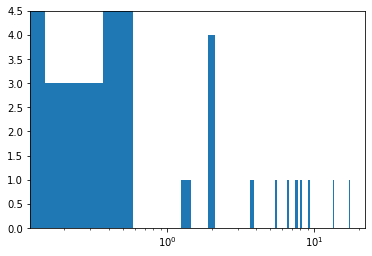

In [16]:
plt.hist(diff,bins=100)
plt.xscale('log')
plt.ylim(0,4.5)

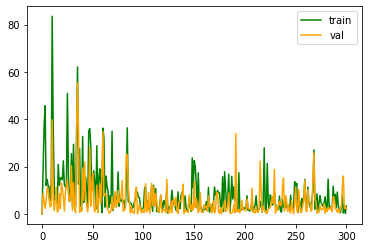

In [18]:
ep = np.arange(0, 300+1)
plt.plot(ep, history_train, label='train', color='green')
plt.plot(ep, history_val, label='val', color='orange')
plt.legend()

[71.71311] [58.101044]
[7.261673] [7.264923]


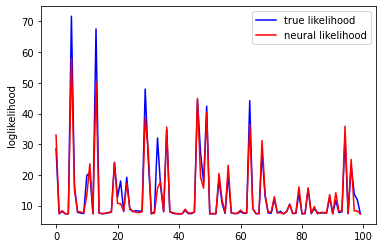

In [19]:
# sns.displot(y_test)
plt.plot(np.sort(y_test.detach().numpy()), color='blue', label='true likelihood')
plt.plot(np.sort(y_pred.detach().numpy()), color='red', label='neural likelihood')
plt.ylabel('loglikelihood')
plt.legend()
print(max(y_test.detach().numpy()), max(y_pred.detach().numpy()))
print(min(y_test.detach().numpy()), min(y_pred.detach().numpy()))

In [20]:
np.shape(y_pred), np.shape(y_test), np.shape(y_pred.detach().numpy())

(torch.Size([100, 1]), torch.Size([100, 1]), (100, 1))

In [21]:
np.shape(history_train), np.shape(history_val)

((301,), (301,))

(0.0, 60.0)

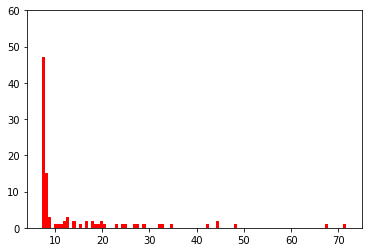

In [22]:
plt.hist(ytest, bins=len(ytest), color='red')
# plt.hist(ypred, bins=len(ypred), color='green')
plt.ylim(0,60)

In [23]:
len(ypred)==len(ytest)

True

In [24]:
len(ypred)

100